# 🧠 Neural Networks from Scratch

**Goal:** By the end of this notebook, you will understand exactly what happens when someone says *"the model is training."* No magic, no hand-waving.

### We'll build a neural network using only NumPy (basic math), train it to solve a problem that a single neuron cannot solve, and then see how PyTorch automates what we did manually.

---

## What We'll Cover

- The XOR Problem — Why we need hidden layers
- Building a Neural Network — Forward pass from scratch
- The Training Loop — Loss, backprop, weight updates
- Watching It Learn — Visualizing training
- Breaking It — What happens with bad hyperparameters
- PyTorch Version — Same thing, less code

---

## Let's go 🚀


# Part 1: The XOR Problem

## Why XOR?

XOR (exclusive or) is a simple logical operation:
- If inputs are **different** → output 1
- If inputs are **the same** → output 0

| Input A | Input B | Output |
|---------|---------|--------|
| 0       | 0       | 0      |
| 0       | 1       | 1      |
| 1       | 0       | 1      |
| 1       | 1       | 0      |

### The Historical Importance

In 1969, Minsky and Papert proved that a single-layer perceptron (one neuron)
**cannot learn XOR**. This caused the first "AI Winter" — people thought neural
networks were fundamentally limited.

The solution? **Hidden layers.** A network with at least one hidden layer CAN
learn XOR. This notebook proves it.


In [336]:
import numpy as np
import matplotlib.pyplot as plt

In [337]:
#our training data: XOR
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

y = np.array([
    [0],
    [1],
    [1],
    [0]
])

In [338]:
print("XOR Dataset:")
print("-"*30)
for i in range(len(X)):
    print(f"Input: {X[i]} → Output: {y[i][0]}")

XOR Dataset:
------------------------------
Input: [0 0] → Output: 0
Input: [0 1] → Output: 1
Input: [1 0] → Output: 1
Input: [1 1] → Output: 0


Visualizing the Problem
Let's plot the XOR data. You'll see why a straight line can't separate the classes.

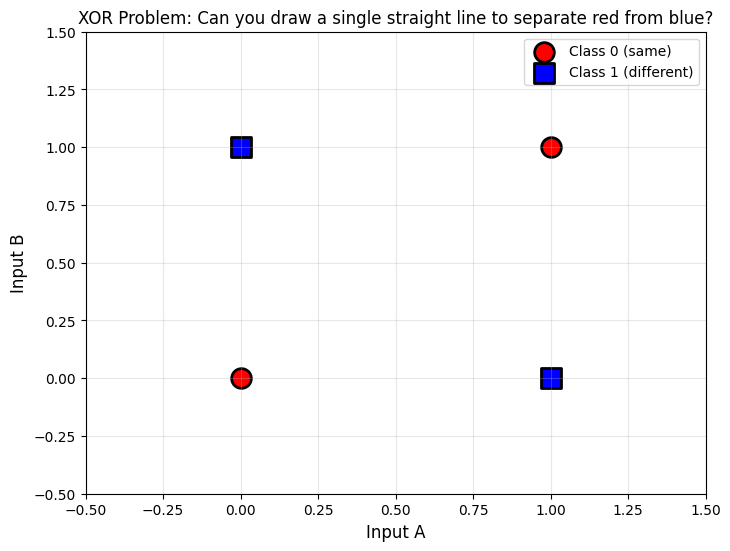


❌ A single straight line CANNOT separate these classes.
✅ This is why we need hidden layers — they create non-linear boundaries.


In [339]:
plt.figure(figsize=(8, 6))
#plot the points
for i in range(len(X)):
    color="red" if y[i][0]==0 else "blue"
    marker= 'o' if y[i][0]==0 else "s"
    plt.scatter(X[i][0],X[i][1],c=color,s=200,marker=marker,edgecolors="black",linewidth=2)
    plt.xlabel('Input A', fontsize=12)
plt.ylabel('Input B', fontsize=12)
plt.title('XOR Problem: Can you draw a single straight line to separate red from blue?',
          fontsize=12)
plt.grid(True, alpha=0.3)

plt.xlim(-0.5,1.5)
plt.ylim(-0.5,1.5)
plt.legend(['Class 0 (same)', 'Class 1 (different)'], loc='upper right')
plt.show()

print("\n❌ A single straight line CANNOT separate these classes.")
print("✅ This is why we need hidden layers — they create non-linear boundaries.")

## 🚀 Part 2: Building the Neural Network

### 🧠 Network Architecture

We will use the following architecture:

- **Input Layer**
  - Takes 2 input values (the two XOR inputs).

- **Hidden Layer**
  - Contains 4 neurons.
  - Uses **sigmoid activation** to introduce non-linearity.

- **Output Layer**
  - Contains 1 neuron.
  - Uses **sigmoid activation** to produce a value between 0 and 1.
  - This output represents the probability of belonging to class 1.

---

### ❓ Why Use Sigmoid Activation?

For this educational example, we use sigmoid activation in all layers because:

- ✅ The output naturally lies between **0 and 1**, matching our target labels.
- ✅ The mathematical formulation is simple and easy to understand.
- ✅ Sigmoid has historical importance in early neural network research.
- ✅ It helps visualize how neural networks transform data step-by-step.

> ⚠️ **Note:**  
> In modern deep learning practice, hidden layers typically use **ReLU** activation because it trains faster and avoids vanishing gradient issues.  
> However, sigmoid is excellent for learning and understanding the fundamentals.


### 🧠 Neural Network Architecture Diagram

        Input Layer            Hidden Layer              Output Layer
       (2 Neurons)             (4 Neurons)               (1 Neuron)

        x1  ─────┐
                 ├──►  h1  ──┐
        x2  ─────┘            │
                               ├──►  Output (ŷ)
        x1  ─────┐            │
                 ├──►  h2  ──┤
        x2  ─────┘            │
                               │
        x1  ─────┐            │
                 ├──►  h3  ──┤
        x2  ─────┘            │
                               │
        x1  ─────┐            │
                 ├──►  h4  ──┘
        x2  ─────┘


In [340]:
#network architecture
INPUT_SIZE = 2    # Two inputs (A and B)
HIDDEN_SIZE = 4   # Four neurons in hidden layer
OUTPUT_SIZE = 1   # One output (0 or 1)

In [341]:
#initilize weights randomly
# using small random values centered around 0.f

In [342]:
# Weights from input to hidden layer (2 inputs → 4 hidden neurons)
weights_input_hidden = np.random.randn(INPUT_SIZE, HIDDEN_SIZE) * 0.5
bias_hidden = np.zeros((1, HIDDEN_SIZE))

In [343]:
# Weights from hidden to output layer (4 hidden neurons → 1 output)
# we assign weights from hidden to output layer -> 4 parameters
weights_hidden_output = np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE) * 0.5
bias_output = np.zeros((1, OUTPUT_SIZE))

In [344]:
print("Network initialized with random weights:")
print(f"  Input → Hidden weights shape: {weights_input_hidden.shape}")
print(f"  Hidden → Output weights shape: {weights_hidden_output.shape}")
print(f"\nTotal parameters: {weights_input_hidden.size + bias_hidden.size + weights_hidden_output.size + bias_output.size}")

Network initialized with random weights:
  Input → Hidden weights shape: (2, 4)
  Hidden → Output weights shape: (4, 1)

Total parameters: 17


## The Activation Function: Sigmoid

Sigmoid squashes any number into the range (0, 1):
- Large positive numbers → close to 1
- Large negative numbers → close to 0
- Zero → exactly 0.5

We also need its derivative for backpropagation.

In [345]:
def sigmoid(x):
    "squash values to range (0,1)"
    return 1/(1+np.exp(-x))
def sigmoid_derivative(x):
    """Derivative of sigmoid: σ(x) * (1 - σ(x))"""
    s=sigmoid(x)
    return s * (1 - s)


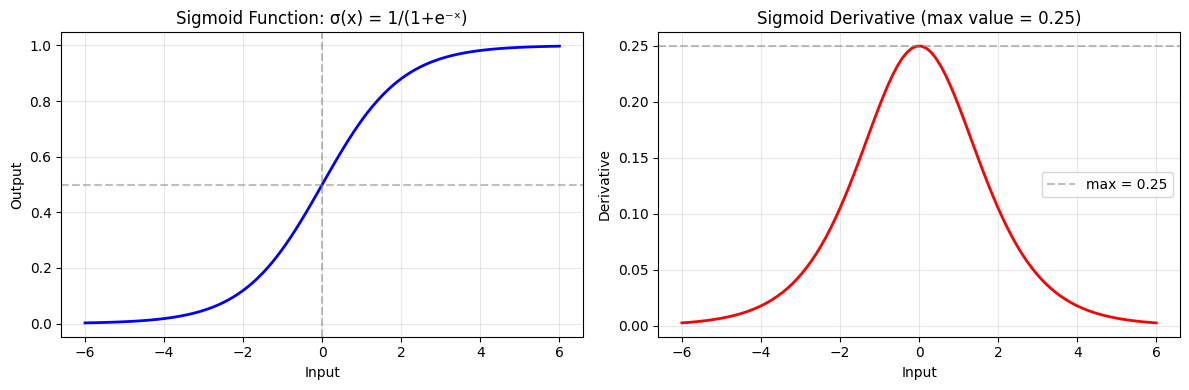

In [346]:
# Visualize sigmoid
x_range = np.linspace(-6, 6, 100)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_range, sigmoid(x_range), 'b-', linewidth=2)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Sigmoid Function: σ(x) = 1/(1+e⁻ˣ)')
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(x_range, sigmoid_derivative(x_range), 'r-', linewidth=2)
plt.axhline(y=0.25, color='gray', linestyle='--', alpha=0.5, label='max = 0.25')
plt.xlabel('Input')
plt.ylabel('Derivative')
plt.title('Sigmoid Derivative (max value = 0.25)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [347]:
print("\nNotice: The maximum derivative is only 0.25!")
print("   This is the vanishing gradient problem.")
print("   10 layers: 0.25^10 = ", 0.25**10)


Notice: The maximum derivative is only 0.25!
   This is the vanishing gradient problem.
   10 layers: 0.25^10 =  9.5367431640625e-07


## Forward Pass

The forward pass is how data flows through the network:

1. **Input → Hidden:** Multiply inputs by weights, add bias, apply activation
2. **Hidden → Output:** Multiply hidden by weights, add bias, apply activation

Let's trace through exactly what happens.

In [348]:
def forward(x):
    """
    Forward pass through the network.
    Returns all intermediate values (we need them for backprop).
    """
    #step 1:Input to Hidden
    #z_hidden = X @ W + b (linear combination)
    z_hidden=np.dot(X,weights_input_hidden)+bias_hidden
    # a_hidden = sigmoid(z_hidden) (activation)
    a_hidden=sigmoid(z_hidden)
    #step 2: Hidden to Output
    z_output=np.dot(a_hidden,weights_hidden_output)+bias_output
    #a_output=sigmoid(z_output)
    a_output =sigmoid(z_output)  
    #return everything(we need z values for backdrop)
    return z_hidden,a_hidden,z_output,a_output


In [349]:
# Test forward pass with untrained network
z_h, a_h, z_o, predictions = forward(X)

In [350]:
print("forwsar pass with untrained network")
print("-",50)
for i in range(len(X)):
    print(f"Input:{X[i]}→ Prediction: {predictions[i][0]:.4f} (Target: {y[i][0]})")
   
print("\n❌ Predictions are garbage — the network hasn't learned anything yet.")

forwsar pass with untrained network
- 50
Input:[0 0]→ Prediction: 0.4927 (Target: 0)
Input:[0 1]→ Prediction: 0.4981 (Target: 1)
Input:[1 0]→ Prediction: 0.5152 (Target: 1)
Input:[1 1]→ Prediction: 0.5188 (Target: 0)

❌ Predictions are garbage — the network hasn't learned anything yet.


## Loss Function: Mean Squared Error

Loss measures **how wrong** our predictions are. Lower = better.

**MSE = mean((prediction - target)²)**

We square the error so:
- All errors are positive
- Big errors are penalized more than small errors

In [351]:
def compute_loss(y_true,y_pred):
    """Mean Squared error"""
    return np.mean((y_true-y_pred)**2)

In [352]:
#calculate initial loss
initial_loss=compute_loss(y,predictions)
print(f"Initial Loss (untrained):{initial_loss:.4f}")
print("\nThis number should decrease as we train.")

Initial Loss (untrained):0.2497

This number should decrease as we train.


# Part 3: Backpropagation

This is where the magic happens. Backprop answers: **"Which weights caused the error, and how much?"**

## The Chain of Blame

1. Calculate error at output
2. Figure out how much each output weight contributed
3. Propagate error back to hidden layer
4. Figure out how much each hidden weight contributed
5. Adjust all weights proportionally

The math uses the chain rule from calculus, but the intuition is simple:
**blame flows backward.**
### The below is the toughest bit to digest

In [353]:
def backward(X, y, z_hidden, a_hidden, z_output, a_output, learning_rate):
    """
    Backpropagation: compute gradients and update weights.
    """
    global weights_input_hidden, bias_hidden, weights_hidden_output, bias_output

    m = X.shape[0]  # Number of training examples

    # ============ OUTPUT LAYER ============
    # Error at output: difference between prediction and target
    output_error = a_output - y  # Shape: (4, 1)

    # Gradient of loss w.r.t. z_output (before activation)
    # This combines the error with the sigmoid derivative
    output_delta = output_error * sigmoid_derivative(z_output)  # Shape: (4, 1)

    # Gradient of loss w.r.t. weights_hidden_output
    # How much did each weight contribute to the error?
    grad_weights_hidden_output = np.dot(a_hidden.T, output_delta) / m
    grad_bias_output = np.mean(output_delta, axis=0, keepdims=True)

    # ============ HIDDEN LAYER ============
    # Propagate error back to hidden layer
    hidden_error = np.dot(output_delta, weights_hidden_output.T)

    # Gradient of loss w.r.t. z_hidden
    hidden_delta = hidden_error * sigmoid_derivative(z_hidden)

    # Gradient of loss w.r.t. weights_input_hidden
    grad_weights_input_hidden = np.dot(X.T, hidden_delta) / m
    grad_bias_hidden = np.mean(hidden_delta, axis=0, keepdims=True)

    # ============ UPDATE WEIGHTS ============
    # Move weights in the opposite direction of the gradient
    # (gradient points uphill, we want to go downhill)
    weights_hidden_output -= learning_rate * grad_weights_hidden_output
    bias_output -= learning_rate * grad_bias_output
    weights_input_hidden -= learning_rate * grad_weights_input_hidden
    bias_hidden -= learning_rate * grad_bias_hidden

print("Backpropagation function defined.")
print("This is the 'learning' part — adjusting weights to reduce error.")

Backpropagation function defined.
This is the 'learning' part — adjusting weights to reduce error.


---
# Part 4: The Training Loop

Now we put it all together:

```
for each iteration:
    1. Forward pass → get predictions
    2. Calculate loss → how wrong are we?
    3. Backward pass → compute gradients, update weights
```

Let's train for 10,000 iterations and watch the loss decrease.

In [354]:
# Reset weights (in case you run this cell multiple times)
np.random.seed(42)
weights_input_hidden = np.random.randn(INPUT_SIZE, HIDDEN_SIZE) * 0.5
bias_hidden = np.zeros((1, HIDDEN_SIZE))
weights_hidden_output = np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE) * 0.5
bias_output = np.zeros((1, OUTPUT_SIZE))

In [355]:
# Hyperparameters
learning_rate = 1.0  # How big our steps are
iterations = 100000   # How many times to loop

In [356]:
# Track loss over time
loss_history = []

In [357]:
print("training started...")
print("-"*50)
for i in range(iterations):
    #forward pass
    z_h, a_h, z_o, predictions = forward(X)
    #calculate loss
    loss = compute_loss(y, predictions)
    loss_history.append(loss)
    #backward pass(updates weights internally)
    backward(X, y, z_h, a_h, z_o, predictions, learning_rate)
     # Print progress
    if i % 2000 == 0:
        print(f"Iteration {i:5d} | Loss: {loss:.6f}")
    

training started...
--------------------------------------------------
Iteration     0 | Loss: 0.255675
Iteration  2000 | Loss: 0.202843
Iteration  4000 | Loss: 0.005199
Iteration  6000 | Loss: 0.001742
Iteration  8000 | Loss: 0.001005
Iteration 10000 | Loss: 0.000696
Iteration 12000 | Loss: 0.000529
Iteration 14000 | Loss: 0.000425
Iteration 16000 | Loss: 0.000355
Iteration 18000 | Loss: 0.000304
Iteration 20000 | Loss: 0.000265
Iteration 22000 | Loss: 0.000235
Iteration 24000 | Loss: 0.000211
Iteration 26000 | Loss: 0.000191
Iteration 28000 | Loss: 0.000175
Iteration 30000 | Loss: 0.000161
Iteration 32000 | Loss: 0.000149
Iteration 34000 | Loss: 0.000139
Iteration 36000 | Loss: 0.000130
Iteration 38000 | Loss: 0.000122
Iteration 40000 | Loss: 0.000115
Iteration 42000 | Loss: 0.000109
Iteration 44000 | Loss: 0.000103
Iteration 46000 | Loss: 0.000098
Iteration 48000 | Loss: 0.000093
Iteration 50000 | Loss: 0.000089
Iteration 52000 | Loss: 0.000085
Iteration 54000 | Loss: 0.000082
Itera

## Let's See the Results!

In [358]:
# Final predictions
_, _, _, final_predictions = forward(X)

print("Final Results After Training:")
print("-" * 50)
print(f"{'Input':<12} {'Target':<10} {'Prediction':<12} {'Rounded':<10}")
print("-" * 50)
for i in range(len(X)):
    pred=final_predictions[i][0]
    rounded=round(pred)
    status = "✅" if rounded == y[i][0] else "❌"
    print(f"{str(X[i]):<12} {y[i][0]:<10} {pred:<12.4f} {rounded:<10} {status}")
print("-" * 50)
print(f"\n🎉 The network learned XOR from random weights!")

Final Results After Training:
--------------------------------------------------
Input        Target     Prediction   Rounded   
--------------------------------------------------
[0 0]        0          0.0075       0          ✅
[0 1]        1          0.9939       1          ✅
[1 0]        1          0.9938       1          ✅
[1 1]        0          0.0058       0          ✅
--------------------------------------------------

🎉 The network learned XOR from random weights!


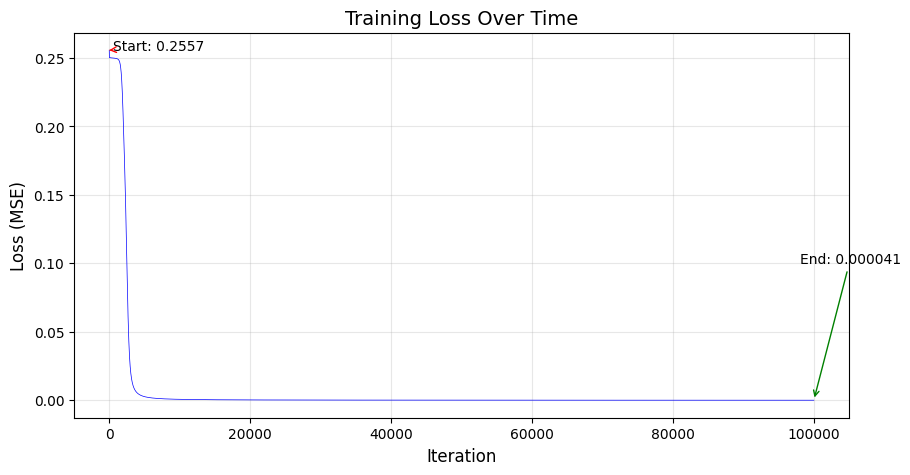

The loss started high (random guessing) and decreased (learning).


In [359]:
# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(loss_history, 'b-', linewidth=0.5)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14)
plt.grid(True, alpha=0.3)

# Add annotations
plt.annotate(f'Start: {loss_history[0]:.4f}',
             xy=(0, loss_history[0]), fontsize=10,
             xytext=(500, loss_history[0]),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.annotate(f'End: {loss_history[-1]:.6f}',
             xy=(len(loss_history)-1, loss_history[-1]), fontsize=10,
             xytext=(len(loss_history)-2000, 0.1),
             arrowprops=dict(arrowstyle='->', color='green'))

plt.show()

print("The loss started high (random guessing) and decreased (learning).")